# Program Specifications

- Two networks of 100 neurons (80 excitatory/20 inhibitory)
- Network topology: random and small world
- Network model: simplified integrate-and-fire model (Model 1) and more complex integrate-and-fire (Model 2)
- Total run time of 1,000 ms
- Display the network model with the functions of the Visualization class
- Plot the raster plot of the simulation using the functions of the BrianVisualization class
- Plot PSTH (peristimulus time histogram)
- Compare the raster plot of the simulation with and without the Poisson inputs to the neurons. 

Contents: 
Line 1 to 7: Python package imports
Line 1 to 95: Visualization class
Line 1 to 183: Brain Visualization class
Line 1 to 51: Adjacency Matrix class

## Importing Python Modules

In [31]:
import networkx as nx
from brian2 import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Defining Classes

### Types: 
* Visualization
* Brian Visualization
* Adjacency Matrix

In [32]:
class Visualization:
    '''
    Function 2: Visualize neural network
    Inputs graph G 
    Returns cluster coefficient & characteristic path length
        & plot of connections between neurons (color-coded)
    For more info: see collective dynamics paper
    
    Description:
    From network model, determines cluster coefficient and characteristic path length for each
        node. For each network, will take average of those values, respectively and yield 
        single integer value.
    From network model, will output plot of connections, color-coded for excitatory and
        inhibitory.
    
    Returns:
        cc_avg: Cluster coefficient averaged over all nodes
        ex_in_plot: Plot of colored excitatory/inhibitory connections
        cpl_avg: Number of edges at shortest path over all nodes 
        
    Parameters:
        G: NetworkX Graph from Function 1
    '''
    def __init__(self):
        #plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows

    def cluster_coeff(self,G):        
        cc = nx.clustering(G) # calculate clustering co-eff according to different rules eg. no of triangles going through node
        # outputs co-eff for all or specified nodes in dict form
        cc_y=[]
        for idx in cc:
            cc_y=np.append(cc_y,cc[idx]) # access and append dict values (co-effs in this case) to array
        
        cc_avg = np.ndarray.mean(cc_y, dtype=np.float64)
        return cc_avg
    
    def ex_in_connec(self,G,connect_W):
        plt.figure()
        red_patch = mpatches.Patch(color='red', label='Excitatory')
        blue_patch = mpatches.Patch(color='blue', label='Inhibitory')
        plt.legend(handles=[red_patch,blue_patch])
        suptitle('Structural Connections', fontsize=14, fontweight='bold')

        edges = G.edges() # list of tuple pairs
        nodes = G.nodes() # array of nodes

        custom_color={}
        for idx in range(len(connect_W)):
            if connect_W[idx] < 0:
                inhib_edge = new_coord[idx]
                G.add_edge(*inhib_edge)
                custom_color[inhib_edge]='b'
            else:
                excit_edge = new_coord[idx]
                G.add_edge(*excit_edge)
                custom_color[excit_edge]='r'
        if 0:
            for idx,idy in enumerate(edges):
                x1,y1 = edges[idx]
                if connect_W < 0:
                    inhib_edge = (x1,y1)
                    G.add_edge(x1,y1)
                    custom_color[x1,y1]='b' # Stores color of edges in dict
                else:
                    excit_edge = (x1,y1)
                    G.add_edge(x1,y1)
                    custom_color[x1,y1]='r'
        
        ex_in_plot=nx.draw_networkx(G,node_color='w',
                         with_labels=True,
                         node_list=nodes,
                         #node_size=50,
                         node_size=200,
                         edge_list=custom_color.keys(),
                         edge_color=custom_color.values(),
                         label='Blue=Inhibitory, Red=Excitatory')
        #plt.savefig("Structural Connections.png")
        
    def char_path_len(self,G):
        cpl = nx.all_pairs_shortest_path_length(G) # shortest path lengths. Gen. returns tuple with source and target dict
        my_array = []
        my_key = []
        cpl_count = []
        for idx in cpl: # looping through each source node and looking at no of targets and length to target nodes
            myarray = cpl[idx[1]] # cpl is a generator object. idx is a tuple (source, target dict). Should be idx[1].
            min_val = min(ii for ii in myarray if ii > 0) # Find min length
            for key,length in myarray.iteritems():
                if length == min_val:
                    my_key = np.append(my_key,key) # array of target nodes with min length for specific source node
            my_count = len(my_key) # Find number of edges of that length
            cpl_count = np.append(cpl_count,my_count)
            my_key = []
            cpl_avg = np.mean(cpl_count) # Find average of those edges
        return cpl_avg

In [33]:
class BrianVisualization:
    '''
    Function 4: Visualization of Brian 
    Define LIF neural population in Brian
    Call to save spike times
    Call to plot voltage monitor
    Call to plot raster plot
    Call to plot histogram
    
    Description:
    Will plot the voltage monitor, raster plot, and histogram of neural network
    
    Returns:
        G: NeuronGroup
        spike_times: Spike times for neuron 0
        all_spikes: Spike times for all neurons
        
    
    Parameters:
        statemon: StateMonitor
        spikemon: SpikeMonitor
        run_time: Simulation run time
    
    '''
    def __init__(self):
        plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows
        
        start_scope()
    
    def network1(self,rows,cols,connect_W,N,PInput):
        # rows and cols 1-D arrays of source and target neurons that are connected as defined in graph from networkx
        # connect_W: 1-D array of strength of connections corresponding to source and target neuron pairs 
        '''
        For full synch: G1.v = fixed
                        PI = off
        '''
        eqs = neuron_diffeqns # Defined in the input parameter block 
                
        G1 = NeuronGroup(N, eqs, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method) #integ_method defined in input parameter block
        #G1.v = 'rand()' #random so changes dynamics for each neuron --> causes difference in raster
        #G1.v = '0.967188882214'
        G1.v = v_c
        '''
        Injection current is constant but with slight perturbations from PoissonInput, if that function is active
        To get rid of highly synchronized, G1.v='rand()' and turn on P1
        '''
        G1.I = I_c # Constant current define in input block 
        G1.tau = tau_m1 * ms
        
        # PoissonInput injection current -- changes each neuron's firing rate
        # Each neuron has different input current depending on Poisson distribution
        PI_num = 0.8*N 
        #subG1 = G1[int(PI_num):] # Top 20% of total neurons stimulated
        subG1 = G1[:] # All neurons stimulated via Poisson 
        '''
        PoissonInput(target,target_var,N,rate,weight)
        target: which neurons to send PoissonInput
        target_var: which variable that is being changed from input
        N: number of inputs (more input = higher firing rate)
        rate: rate of input (100Hz = 10ms per spike)
        weight: amount added to voltage
        '''
        #P1 = PoissonInput(subG1, 'v', 5, 100*Hz, weight=0.1) # PoissonInput on
        P1 = PoissonInput(subG1, 'v', 5, 100*Hz, weight=PInput) # PoissonInput off if PInput = 0

        
        S1 = Synapses(G1, G1, 'w : volt', on_pre='v_post += w') # w is the synapse weight added to the signal
        S1.connect(i=rows, j=cols) # Adjacency matrix from Adj.weighted, this uses network structure defined on networkx
        S1.w = connect_W/float(100) # Weighted matrix defined from networkx graph 
               
        return G1,S1,P1
    
    def network2(self,rows,cols,connect_W,N,PInput):
        '''
        Start off w/ identical network parameters as network 1, but need to eventually change connect_W (its interconnections)
        If P2 turned on, may need to increase S3.w so network 1 influence is higher than PoissonInput
        '''
        eqs = neuron_diffeqns # Defined in the input parameter block

        G2 = NeuronGroup(N, eqs, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method)
        #G2.v = '0.967188882214' # For debugging of coupling so that all nodes in G2 will fire at same rate
        #G2.v = 'rand()'
        G1.v = v_c
        G2.I = I_c
        G2.tau = tau_m2 * ms
        
        subG2 = G2[:]
        P2 = PoissonInput(subG2, 'v', 5, 100*Hz, weight=PInput) #PoissonInput on if PInput = 0.1
        
        S2 = Synapses(G2, G2, 'w: volt', on_pre='v_post += w')
        S2.connect(i=rows, j=cols) # Network 2 has same inter-network connections as Network 1
        S2.w = connect_W/float(100)
        
        return G2,S2,P2

    def network_coupling(self,N,p_couple,w_couple,G1,G2):
        '''
        Should see how coupling between different subpopulation has global effects (raster plot)
            - Could see difference if neurons have same firing rate (non-PoissonInput) vs. different firing rate (all-PoissonInput)
            - May only want to record (Statemon, Spikemon) from this last coupling (G2) to save resources
                - See Monitoring Synaptic Variables from http://brian2.readthedocs.io/en/2.0.1/user/synapses.html
            = Can introduce multiple output synapses (multisynaptic_index from http://brian2.readthedocs.io/en/2.0.1/user/synapses.html)
                - Or more simply "S.connect(i=numpy.arange(10), j=1)"
        '''
        S3 = Synapses(G1,G2, 'w:1', on_pre='v_post += w')#, delay=5*ms) # G1 drives G2
        
        ### Manually defining coupling ###
        p_couple2 = p_couple*N
        i_couple = 0.8*N
        
        # If want 1:1 for only first p_couple% neurons (excitatory --> excitatory)
        c_rows = list(arange(0,p_couple2,dtype=int)) # Source neurons
        c_cols = list(arange(0,p_couple2,dtype=int)) # Target neurons
        
        # If want 1:1 for only last p_couple% neurons 
        #c_rows = list(arange(N-p_couple2,N,dtype=int))
        #c_cols = list(arange(N-p_couple2,N,dtype=int))
        
        # If want 1:1 for inhibitory onto inhibitory neurons
        #c_rows = list(arange(N-i_couple,N,dtype=int))
        #c_cols = list(arange(N-i_couple,N,dtype=int))        
        
        # If want 1:1 for projection of excitatory onto inhibitory neurons
        #c_rows = list(arange(0,p_couple2,dtype=int))
        #c_cols = list(arange(N-i_couple,N,dtype=int))
        
        # If want 1:! for projection of inhibitory onto excitatory neurons
        #c_rows = list(arange(N-p_couple2,N,dtype=int))
        #c_cols = list(arange(0,p_couple2,dtype=int))
        
        S3.connect(i=c_rows, j=c_cols) # Manually defined coupling
        S3.w = w_couple
        ###################################
        
        ##### Probabilistic coupling #####
        #S3.connect(p=0.05) # Probabilistic connection - Chance that G2 will connect with and spike from G1
        #S3.w = 0.02
        #S3.connect(p=p_couple)
        ###################################
                
        # Coupling matrix
        coup_mat = [[0 for x in range(N)] for y in range(N)]

        for ii in range(len(c_rows)):
            for jj in range(len(c_cols)):
                coup_mat[ii][ii] = 1      # Matrix has 1s for connections and 0s for none

        statemon1 = StateMonitor(G1, 'v', record=0) # Records just neuron 0 to save resources
        spikemon1 = SpikeMonitor(G1, variables='v')
        statemon2 = StateMonitor(G2, 'v', record=0) # Records just neuron 0 to save resources
        spikemon2 = SpikeMonitor(G2, variables='v')
                
        run(run_time*ms, 'text')

        return statemon1,spikemon1,statemon2,spikemon2,c_rows,c_cols,coup_mat
        
    def spike_time(self,spikemon):
        all_values = spikemon.all_values()
        spike_times = all_values['t'][0] # Spike times for just neuron 0
        all_spikes = spikemon.t/ms # Spike times for all neurons
        
        return spike_times,all_spikes
        
    def voltage_monitor(self,statemon):
        plot(statemon.t/ms, statemon.v[0])
        #plot(statemon.t/ms, statemon.v[1])  # Plots second neuron      
        ylabel('Voltage (V)')
        xlabel('Time (ms)')
        
    def raster_plot(self,spikemon,spikemon_other):
        #ion()
        plot(spikemon.t/ms, spikemon.i, '.r')
        plot(spikemon_other.t/ms, spikemon_other.i, '.k') # Plots overlay of each network
        xlabel('Time (ms)')
        ylabel('Neuron index');
        #plt.show(block=True)
        
    def spike_hist(self,run_time,all_spikes):
        my_bins = arange(0,run_time+2,2)
        plt.hist(all_spikes, bins=my_bins)
        xlabel('Time (ms)')
        ylabel('Total number of spikes')

In [34]:
class AdjacencyMatrix:  
    '''
    Function 1: Weighted adjacency matrix
    Call to initiate adjacency matrix
    Call to choose which neural network topology with given parameters
    
    Description:
    Given parameters, constructs network with adjacency matrix and applies random weights.
    
    Returns:
        G: NetworkX Graph
        A: Adjacency matrix. Sparse matrix
        rows: Presynaptic neurons
        cols: Postsynaptic neurons
        connect_W: Weights for each E/I connection (in order of rows,cols)
    
    Parameters:
        n: nodes
        m: edges
        k: neighbor connections
        p: probability 
        d: degrees
    '''
    def __init__(self,n): 
        plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows
        
    def random(self,n,p): 
        # Interchangeable based on UI for different types of topography
        #G = nx.dense_gnm_random_graph(n,m) # Uses NetX to generate random topography, need to add input param m
        G = nx.gnp_random_graph(n,p)
        #nx.draw(G, with_labels=True) # Draws connectivity figure
        #plt.savefig("Random.png") # Saves connectivity figure as Random.png

        # Extracts ADJACENCY MATRIX from topography and rearranges to manageable array of (n*n) elements
        A = nx.adjacency_matrix(G) # Assigns A as adjacency matrix (which nodes are connected)
        return A, G 
    
    def small_world(self,n,k,p): 
        G = nx.newman_watts_strogatz_graph(n,k,p) 
        #nx.draw(G, with_labels=True)
        #plt.savefig("Small-world.png")
        A = nx.adjacency_matrix(G)
        return A, G
    
    def unidir_coord(self,rows, cols):
        # function to remove duplicate connections like (0,3) and (3,0) so that all connections are uni- and not bi-directional
        new_coord = zip(rows,cols) # To get an array of coordinate pair tuples, to define node pairs or edges 
        #print new_coord
        new_rows = set(tuple(sorted(l)) for l in new_coord) # set removes duplicate tuples that are now ordered pairs
        # set(array of tuples)
        g = np.array(list(new_rows)) #array of 1 by 2 neuron pair vectors that are connected to each other
        # In each 1 by 2 vector: column 0 is source neuron and column 1 is target neuron
        new_rows = g[:,0] #1-D array of all source neurons i
        new_cols = g[:,1] #1-D array of all target neurons j
        new_coord = zip(rows,cols) # list of tuples, source and target ordered pairs with no duplicates
        return new_coord, new_rows, new_cols
    
    def adj_synapse_type(self,A):
        ### Define connections as inhibitory or excitatory in the adjacency matrix
        A_mat = A.todense() # Converts adjacency matrix from 'scipy.sparse.csr.csr_matrix' to numpy matrix                              
        rows, cols = np.nonzero(A_mat) # Two arrays of index positions for connections
        [new_coord, new_rows, new_cols] = self.unidir_coord(rows,cols) # Removes duplicate connections
        connect = len(new_rows) # number of connections or 1s in adjacency matrix

        for i in range(connect):
            x = new_rows[i]
            y = new_cols [i]
            if x>(excit-1) or y>(excit-1):   # Checking if either source or target neuron belongs to upper 20% of n 
                A_mat[x,y] = A_mat[x,y]*-1   # Inhibitory neuron defined, weight is made negative

        # Constructing array of unweighted connections
        connect_A = [] # Initializaing empty connections array
        for i in range(connect):
            x = new_rows[i]
            y = new_cols [i]
            connect_A.append(A_mat[x,y])
        connect_A = np.array(connect_A) # Converting data type list to numpy array
        return connect_A,new_coord,new_rows,new_cols

In [35]:
class Spike_Stats:
    '''
    Description: Given spike times of each neuron, statistical parameters of ISI(Inter-Spike-Interval) can be calculated
                 like mean, variance, co-efficent of variation. Spike trains can also be compared to produce correlation
                 coefficients
    
    Parameters: 
    '''
    
    def __init__(self): # Not sure what to do here yet
        pass
    
    def ISI_stats(self,spikemon):
        neuron_spikes = spikemon.spike_trains() # Dictionary with dict keys as neuron indices and 
                                         # dict values as an array of spike times for that neuron
        firing_n = list(set(sort(spikemon.i))) # To create a set or list of all unique neuron indices that have spiked
                                                # in order to calculate statistical parameters for each unique neuron
            
        ISI = {} # Create an empty dictionary to contain dict keys as neuron indices and dict values as an array of ISIs
        ISI_mean = {} # Dict for ISI mean of each neuron index
        ISI_var = {} # Dict for ISI variance of each neuron index
        ISI_cv = {} # Dict for ISI co-efficient of variation (CV) for each neuron index
        full_tseries = []

        # Calculate variance and mean of each ISI (Inter-Spike-Interval)
        for i in firing_n:
            # Calculate ISI array by subtracting spike times of each neuron to get an array of spike intervals
            ISI[i] = np.diff(neuron_spikes[i])
            # Calculate mean of ISI
            ISI_mean[i] = np.mean(ISI[i])
            # Calculate variance of ISI
            ISI_var[i] = np.var(ISI[i])
            # Calculate co-efficient of variation(CV) of ISI
            ISI_cv[i] = np.sqrt(ISI_var[i])/ISI_mean[i]
        return ISI,ISI_mean,ISI_var,ISI_cv
    
    def spike_bin(self,ISI,bin_size):
        sp_binary = {}
        t_interval = range(0,run_time,bin_size)
        t_size = len(t_interval)

        for k in ISI:
            temp = [0]*t_size
            count= 0
            for t in t_interval: # for loop to search for spikes in the current time interval
                #print(count)
                for r in ISI[k]: # looks through all spike times to see if any are within the current time interval
                    if r>t*ms and r<=(t+bin_size)*ms:
                        temp[count] = 1
                        break    # breaks out of for loop when at least one spike has been found for the time interval 
                                 # and moves on to the next time interval
                    else:
                        temp[count] = 0
                count = count + 1
            sp_binary[k] = temp
        return sp_binary

    def spike_cc(self,bin_vector):
        var = [] # A empty list that will contain lists of binary spike trains
        for k in bin_vector:
            var.append(bin_vector[k]) # Required format to use with numpy's corrcoef function

        CC_matrix = np.corrcoef(var) # This matrix is N-neurons by N-neurons and the main diagonal is all 1s 
                                     # test with try CC_matrix.shape to confirm
        return CC_matrix

## Defining Input Parameters

In [36]:
# Define network parameters

'''
Network Architecture Variables:
    n - number of nodes/neurons
    p - probability for an edge to be formed between two nodes
    p_sm - probability in a small-world network 
    k - each node is connected to k nearest neightbors
    rand_seed - method of generating a random number, in this case, one based on time
    excit - number of excitatory neurons
    inhib - number of inhibitory neurons
    connect_A - the unweighted version of connect_W, a 1-D array of excitatory(1) and inhibitory(-1) connections
'''
n = 100
p = 0.2
p_sm = 1 
k = 2
rand_seed = np.random.seed(int(time.time())) # To seed random number generator based on time
excit = int(0.8*n) # 80% of total neurons
inhib = int(0.2*n)

'''
Network Simulation Variables:
    N: number of neurons
    tau_m: time constant (ms)
    v_r = reset membrane potential (mv)
    v_th = threshold membrane potential (mv)
    I_c = external depolarizing current that is constant
    run_time = simulation time (ms)
    p_couple = probability that neuron i in first net will couple with neuron i in second net
    PInput = Poisson Input: weight = 0 for off and 0.1 for on
'''
N = n 
v_r = 0*volt
v_th = 1*volt  
run_time = 1000
#p_couple = 0.1 #0.99
integ_method = 'euler' # or can use 'linear' if differential equation is linear
bin_size = 1 # Units are ms, do NOT add them here. It will be added in Stats class under spike_bin function

'''
Individual Neuron dynamics
    E_K = reverse potential for Potassium across lipid bilayer
    E_Na = reverse potential for Sodium across lipid bilayer
    E_L = leakage potential to account for the exchange of all other ions across cell membrane
    dia = diameter of post-synaptic surface
    length = length of post-synaptic surface
    SA = surface area of post-synaptic neuron
    gL = conductance of leakage channels
    C_mem = membrane capacitance
    E_ex = reversal potential of excitatory synaptic potential eg. AMPA
    E_i = reversal potential of inhibitory synaptic potential eg. GABA 
'''
#E_K = -80*mV
#E_Na = 20*mV
E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*volt
I_c = 10*pamp # same as I_ext
tau_m1 = 0
tau_m2 = 0
tau_ge = 5*ms
tau_gi = 2*ms

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau : second
'''

# Leaky integrate and fire neuron (from previous code) 
# NOTE:Need to include cell resistance so that (RI - v) dimensions match
#R = 1*ohm # Assumption for cell resistance
#I_c = 2*amp
#tau_m1 = 20.4 #37
#tau_m2 = 32.4 #43

model_1 = '''                
dv/dt = (R*I-v)/tau : volt (unless refractory)
I : ampere
tau : second
'''   

neuron_diffeqns = model_2    

## Creating Network Models

In [37]:
### Creating a network of 100 neurons and its corresponding adjacency matrix

Adj = AdjacencyMatrix(n) # Initiates an instance of AdjacencyMatrix class

# Network 1: Random
[A,G] = Adj.random(n,p) # Defines random topology using nodes, n and probability, p
                        # NetworkX used to generate random graph topography
                        # Creates adjacency matrix. For indexes, rows: source neurons, columns: target neurons. 
                        # 1s indicate nodes connected by an edge, 0s for the opposite

# To produce an adjacency matrix with weights adjusted according to excitatory(+ve weight) or inhibitory synapse(-ve weight)
[connect_A,new_coord,new_rows,new_cols] = Adj.adj_synapse_type(A)

# Network 2: Small World
# Same process as for Network 1
Adj = AdjacencyMatrix(n) # Initiates an instance of AdjacencyMatrix class
[A_sm,G_sm] = Adj.small_world(n,k,p_sm)
[connect_A_sm, new_coord_sm,new_rows_sm,new_cols_sm] = Adj.adj_synapse_type(A_sm)


For random network 1, the clustering co-efficient is 0.1986939656890639
For small-world network 2, the clustering co-efficient is 0.040999999999999995

Connection Types in the Random Network


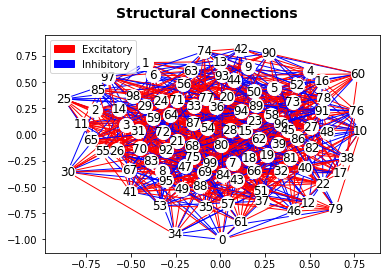

In [38]:
### Using functions in the Visualization class

vis = Visualization() # Initializing the class

cluster = vis.cluster_coeff(G)
print ("For random network 1, the clustering co-efficient is"), cluster

## Same process for small-world, Network 2
cluster = vis.cluster_coeff(G_sm)
print ("For small-world network 2, the clustering co-efficient is"), cluster

print ("\nConnection Types in the Random Network")
vis.ex_in_connec(G,connect_A) # This function also uses new_coord returned from AdjacencyMatrix class, adj_synapse_type func

#char_pl = vis.char_path_len(G)
#print "Characteristic path length is", char_pl

#print "\nConnection Types in the Small-world Network"
#vis.ex_in_connec(G_small,connect_A_small) 
# This function also uses new_coord returned from AdjacencyMatrix class, adj_synapse_type func


## Simulating the Network Model

In [39]:
### Simulating the network
connect_W = connect_A*volt

# Initializing BrianVis class
BrianVis = BrianVisualization()

# Run LIF model for first network with Poisson input
PInput = 0.1*volt
[G1,S1,P1] = BrianVis.network1(new_rows,new_cols,connect_W,N,PInput) # Modified Brian network 1 and 2 class def for PInput
spikemon1 = SpikeMonitor(G1)

# Run LIF model for second network with Poisson input
PInput = 0.1*volt
connect_W_sm = connect_A_sm*volt
[G2,S2,P2] = BrianVis.network2(new_rows_sm,new_cols_sm,connect_W_sm,N,PInput) # Modified Brian class def for PInput
spikemon2 = SpikeMonitor(G2)

run(run_time*ms) # This simulates both network1 and network2 defined above


Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler


## Simulation Results

<Figure size 432x288 with 0 Axes>

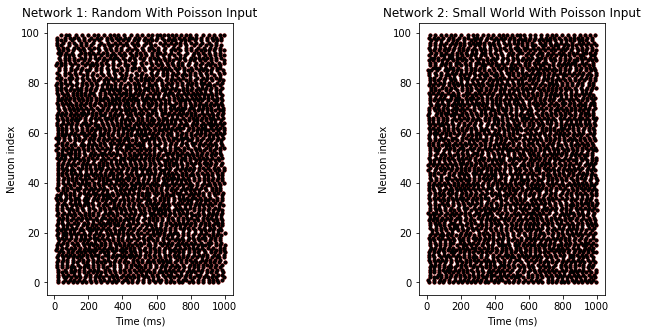

In [40]:
### Plotting raster plot
fig1 = plt.figure() 
fig1.suptitle("Raster plots for Random Networks")
plt.subplots(figsize=(10,5)) # Increasing the figure size 
plt.subplots_adjust(wspace = 1) # Change width between subplots

ax = plt.subplot(1,2,1)
ax.set_title("Network 1: Random With Poisson Input")
BrianVis.raster_plot(spikemon1,spikemon1)

ax = plt.subplot(1,2,2)
ax.set_title("Network 2: Small World With Poisson Input")
BrianVis.raster_plot(spikemon2,spikemon2)

<Figure size 432x288 with 0 Axes>

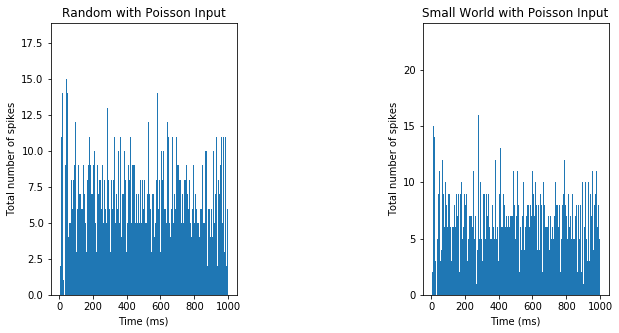

In [41]:
### Plotting PSTH plot

# Gather data for network 1
[spike_times1,all_spikes1] = BrianVis.spike_time(spikemon1)

# Gather data for network 1
[spike_times2,all_spikes2] = BrianVis.spike_time(spikemon2)

fig2 = plt.figure()
fig2.suptitle("PSTH plots for Random Networks")
plt.subplots(figsize=(10,5)) # Increasing the figure size 
plt.subplots_adjust(wspace = 1) # Change width between subplots

ax = plt.subplot(1,2,1)
ax.set_title("Random with Poisson Input")
BrianVis.spike_hist(run_time,all_spikes1)

ax = plt.subplot(1,2,2)
ax.set_title("Small World with Poisson Input")
BrianVis.spike_hist(run_time,all_spikes2)

## Calculating Statistical Parameters

In [42]:
def spike_stat(spikemon):
    # provide a pairs showing index and spike times of neurons
    list_of_pairs = zip(*spikemon.it)
    # represent neuron index in an array
    neuron_index_list = list(spikemon.i)
    # represent neuron spike times in a separate array
    spike_time_list = list(spikemon.t)
    index_array, time_array = spikemon.i, spikemon.t

    # make a dictionary where each index represents the 
    # neuron index and the corresponding array represents all spike times of the neuron
    from collections import defaultdict
    neuron_spikes = defaultdict(list)
    for index,value in enumerate(index_array):
        neuron_spikes[value] += [time_array[index]]
    for l in neuron_spikes:
        neuron_spikes[l] = sorted(neuron_spikes[l])
    # find the difference between the spike times 
    for g in neuron_spikes:
        lis = neuron_spikes[g]
        l = list()
        for index,f in enumerate(lis):
            if(index+1 >= len(neuron_spikes[g])):
                continue
            else:
                l += [(lis[index+1]/ms)-(f/ms)]
        neuron_spikes[g] = l
    # make a function to calculate average
    def avg(numbers):
        return float(sum(numbers)) / max(len(numbers), 1)
    mean = []
    std = []
    # find the standard deviation
    for liss in neuron_spikes:
        lists = neuron_spikes[liss]
        std.append(numpy.std(lists))
        mean.append(avg(lists))
     # find the coefficient of variance by dividing mean by std
    cv = []
    for s in range(100): 
        cv.append(std[s]/mean[s])   

    return numpy.round(mean,2),numpy.round(std,2),numpy.round(cv,2)

In [43]:
# Calculate ISI mean, variance and co-efficient of variation from spike times
stats = Spike_Stats() # Initialize Spike Stats class
[ISI,ISI_mean,ISI_var,ISI_cv] = stats.ISI_stats(spikemon1)
[ISI2,ISI2_mean,ISI2_var,ISI2_cv] = stats.ISI_stats(spikemon2)

# Create binary spike trains, put into stats class
sp_binary = stats.spike_bin(ISI,bin_size)
sp2_binary = stats.spike_bin(ISI2,bin_size)

# Calculating correlation co-efficient
CC_matrix = stats.spike_cc(sp_binary)
CC2_matrix = stats.spike_cc(sp2_binary)

In [44]:
CC_matrix.shape

(100L, 100L)

### Correlation co-efficient Heat Map

<Figure size 432x288 with 0 Axes>

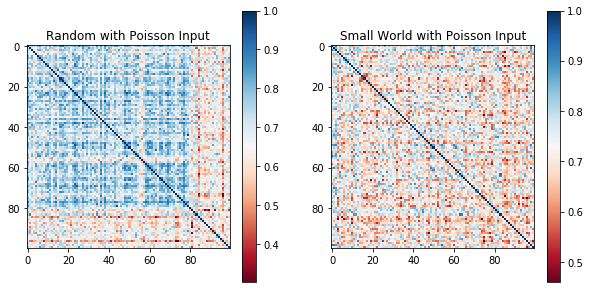

In [54]:
# Generating a heat map
fig3 = plt.figure()
plt.subplots(figsize=(10,5)) # Increasing the figure size 
#plt.subplots_adjust(wspace = 1) # Change width between subplots

ax1 = plt.subplot(1,2,1)
ax1.set_title("Random with Poisson Input")
map = plt.imshow(CC_matrix,cmap = 'RdBu') # Blue gives maximum correlation while red shows least correlation
plt.colorbar(map) # To show the legend of colors with corresponding values form matrix            

ax2 = plt.subplot(1,2,2)
ax2.set_title("Small World with Poisson Input")
map2 = plt.imshow(CC2_matrix,cmap = 'RdBu') # Blue gives maximum correlation while red shows least correlation
plt.colorbar(map2)